# GRAPE for systems with Dissipation

In [1]:
# ruff: noqa

In [2]:
import jax.numpy as jnp
from feedback_grape.grape import *
from feedback_grape.utils.gates import *
from feedback_grape.utils.operators import *
from feedback_grape.utils.states import *
from feedback_grape.utils.superoperator import *
from feedback_grape.utils.tensor import *

In [3]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Sm = sigmam()
Si = identity(2)
had_gate = hadamard()
# Hamiltonian
Del = 0.1  # Tunnelling term
wq = 1.0  # Energy of the 2-level system.
H0 = 0.5 * wq * sigmaz() + 0.5 * Del * sigmax()
H_ctrl = [Sz, Sx]  # Controls for the Hamiltonian
# Amplitude damping#
# Damping rate:
gamma = 0.1
L0 = liouvillian(H0, [jnp.sqrt(gamma) * Sm])
c_ops = [jnp.sqrt(gamma) * Sm]


# sigma X control
LC_x = liouvillian(Sx)
# sigma Z control
LC_z = liouvillian(Sz)

# Drift
drift = L0
# Controls - different combinations can be tried
ctrls = [LC_z, LC_x]
# Number of ctrls
n_ctrls = len(ctrls)

# start point for the map evolution
E0 = sprepost(Si, Si)

# target for map evolution
E_targ = sprepost(had_gate, had_gate)

In [4]:
print(fidelity(U_final=E_targ, C_target=E_targ, type="liouvillian"))

1.0


In [5]:
# Number of time slots
n_ts = 10
# Time allowed for the evolution
evo_time = 2

In [23]:
result = optimize_pulse(
    H_drift=drift,
    H_control=ctrls,
    U_0=E0,
    C_target=E_targ,
    num_t_slots=n_ts,
    total_evo_time=evo_time,
    type="liouvillian",
    optimizer="adam",
    convergence_threshold=1e-16,
    max_iter=10000,
    learning_rate=0.35,
    propcomp="memory-efficient",
)

In [24]:
result

result(control_amplitudes=Array([[ 2.71082027,  4.48791631],
       [-0.67486112, -0.7010955 ],
       [-2.13670958, -4.18459458],
       [ 3.81798346, -3.23149726],
       [-2.56614879,  0.5560324 ],
       [-6.21675663,  2.06667398],
       [ 2.44055923,  4.73374016],
       [-1.06365938, -4.49567141],
       [-2.36388854, -6.23382583],
       [-3.3986097 ,  4.24182892]], dtype=float64), final_fidelity=Array(0.99744946, dtype=float64), iterations=10000, final_operator=Array([[-6.07743266e-01 +0.96661676j, -1.07355260e+00 +5.27140929j,
        -3.40834544e-01 -0.43444818j,  3.74965506e-01 -1.81390207j],
       [ 2.50604722e-01 -0.12801061j,  7.56255378e-01 -1.06782213j,
         8.60125504e-02 +0.1382318j ,  2.21738237e-03 +0.3901996j ],
       [-6.18024760e+00 +4.16905843j, -6.81644036e-01+26.61939032j,
        -7.93931238e-01 -1.71180115j,  3.66917277e-01 -7.54581802j],
       [ 1.60774327e+00 -0.96661676j,  1.07355260e+00 -5.27140929j,
         3.40834544e-01 +0.43444818j,  6.25034

In [22]:
result1 = optimize_pulse(
    H_drift=H0,
    H_control=H_ctrl,
    U_0=Si,
    C_target=had_gate,
    c_ops=c_ops,
    num_t_slots=n_ts,
    total_evo_time=evo_time,
    type="liouvillian",
    optimizer="adam",
    convergence_threshold=1e-16,
    max_iter=1000,
    learning_rate=0.001,
    propcomp="time-efficient",
)

In [8]:
result1

result(control_amplitudes=Array([[ 0.19529909,  0.00613831],
       [ 0.28778066,  0.45642727],
       [ 0.35883707,  0.40212176],
       [ 0.33137309,  0.3675654 ],
       [ 0.07480631,  0.15763996],
       [ 0.07807701,  0.02821956],
       [ 0.38201447,  0.50845528],
       [ 0.29653459,  0.14071591],
       [-0.05892553,  0.39245506],
       [ 0.06727997,  0.60584379]], dtype=float64), final_fidelity=Array(0.99977216, dtype=float64), iterations=1000, final_operator=Array([[-0.00045568-0.89994329j,  0.10804541-0.42240745j],
       [-0.10804541-0.42240745j, -0.00045568+0.89994329j]],      dtype=complex128))

In [9]:
print(
    fidelity(
        C_target=had_gate, U_final=result1.final_operator, type="liouvillian"
    )
)

0.9997721576086267


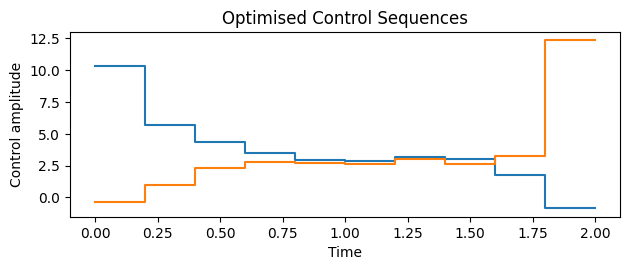

In [10]:
import numpy as np

time = np.linspace(0, evo_time, n_ts + 1)
fig1 = plt.figure()

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Sequences")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(
        time,
        np.hstack(
            (result.control_amplitudes[:, j], result.control_amplitudes[-1, j])
        ),
        where="post",
    )
fig1.tight_layout()